In [1]:
import ast
import math
import random
import my_kmeans
import pandas as pd
import matplotlib.pyplot as plt


global hotelCor
hotelCor = [52.5591794, 29.6088092]

inja
wtf
cluster
0    176
2      5
1      1
3      1
Name: count, dtype: int64


/home/nargess/Documents/vscodeRepos/GA---K-means-for-TOP-/my_kmeans.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['latitude'] = X['latitude'].apply(lambda x: 100000*x)
/home/nargess/Documents/vscodeRepos/GA---K-means-for-TOP-/my_kmeans.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['longitude'] = X['longitude'].apply(lambda x: 100000*x)


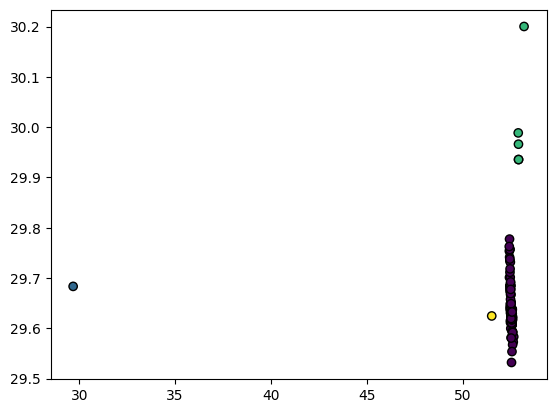

In [9]:
df = pd.read_csv("/home/nargess/Downloads/shiraz.csv")
df.rename(columns={'slug_category':'category'}, inplace=True)
df.rename(columns={'average_rating':'rate'}, inplace=True)


df['coordinates'] = df['coordinates'].apply(lambda x: ast.literal_eval(x))
# print(df.head(20))


# plt.figure(figsize=(10, 10))
# plt.scatter(df['latitude'], df['longitude'], cmap='viridis', marker='o', edgecolor='k')

# plt.show()


# df["coordinates"][0]
my_kmeans.add_clusters(df, 4)
print(df.value_counts(df['cluster']))

plt.scatter(df['latitude'], df['longitude'], c=df['cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.show()


In [3]:
def vlox_crossover(parent1, parent2):
    # Get lengths of the parents
    size1, size2 = len(parent1), len(parent2)
    
    # Determine crossover points for both parents
    p1_start, p1_end = sorted(random.sample(range(size1), 2))
    p2_start, p2_end = sorted(random.sample(range(size2), 2))
    
    # Create the child initialized to None
    child = [None] * max(size1, size2)
    
    # Copy the segment from the first parent to the child
    child[:p1_end - p1_start] = parent1[p1_start:p1_end]
    
    # Add the segment from the second parent into the child, preserving order and avoiding duplicates
    remaining_positions = [i for i, x in enumerate(child) if x is None]
    segment2 = parent2[p2_start:p2_end]
    remaining_segment2 = [x for x in segment2 if x not in child]
    
    for i, location in zip(remaining_positions, remaining_segment2):
        child[i] = location
    
    # Fill the remaining positions with the rest of parent2, preserving order and avoiding duplicates
    current_index = remaining_positions[len(remaining_segment2):]
    for location in parent2:
        if location not in child and current_index:
            child[current_index.pop(0)] = location
    
    # Trim any None values for the final valid child tour
    child = [location for location in child if location is not None]
    
    return child

# Example usage
parent1 = ['A', 'B', 'C', 'D', 'E']
parent2 = ['B', 'D', 'A', 'E', 'C', 'F']

child = vlox_crossover(parent1, parent2)
print("Child:", child)


Child: ['B', 'C', 'D', 'A', 'E', 'F']


In [4]:
def swap_mutation(tour, mutation_rate=0.1):
    if random.random() < mutation_rate:
        idx1, idx2 = random.sample(range(len(tour)), 2)
        tour[idx1], tour[idx2] = tour[idx2], tour[idx1]
    return tour

def insertion_mutation(tour, mutation_rate=0.1):
    if random.random() < mutation_rate:
        idx1, idx2 = random.sample(range(len(tour)), 2)
        location = tour.pop(idx1)
        # Ensure no duplicates and all locations are included
        if location not in tour:
            tour.insert(idx2, location)
    return tour

def scramble_mutation(tour, mutation_rate=0.1):
    if random.random() < mutation_rate:
        start, end = sorted(random.sample(range(len(tour)), 2))
        sublist = tour[start:end]
        random.shuffle(sublist)
        tour[start:end] = sublist
    return tour

def inversion_mutation(tour, mutation_rate=0.1):
    if random.random() < mutation_rate:
        start, end = sorted(random.sample(range(len(tour)), 2))
        tour[start:end] = reversed(tour[start:end])
    return tour

In [5]:
def crossover_and_mutate(parent1, parent2, mutation_rate=0.1):
    # Perform crossover to create a child
    child = vlox_crossover(parent1, parent2)
    print(child)
    
    # List of available mutation functions
    mutations = [swap_mutation, insertion_mutation, scramble_mutation, inversion_mutation]
    
    # Randomly select one mutation function
    mutation_function = random.choice(mutations)
    
    # Apply the selected mutation function to the child
    mutated_child = mutation_function(child, mutation_rate)
    
    # Ensure no duplicates and all locations are included
    missing_locations = set(parent1) - set(mutated_child)
    duplicate_locations = set([loc for loc in mutated_child if mutated_child.count(loc) > 1])
    
    for duplicate in duplicate_locations:
        for missing in missing_locations:
            
            idx = mutated_child.index(duplicate)
            mutated_child[idx] = missing
            break
    
    return mutated_child

# Example Usage
parent1 = ['A', 'B', 'C', 'D', 'E']
parent2 = ['B', 'D', 'A', 'E', 'C', 'F']

# Generate a child with crossover and mutation
child = crossover_and_mutate(parent1, parent2, mutation_rate=0.2)
print("Child after crossover and mutation:", child)

['B', 'C', 'D', 'A', 'E', 'F']
Child after crossover and mutation: ['B', 'C', 'D', 'A', 'E', 'F']


In [6]:
def generate_initial_population(num_tours, min_locations, max_locations, df):
    """
    Generate an initial population of random tours.

    Parameters:
    num_tours (int): Number of tours to generate.
    min_locations (int): Minimum number of locations in each tour.
    max_locations (int): Maximum number of locations in each tour.
    df (pd.DataFrame): Dataframe containing location information.

    Returns:
    list of lists: A list of tours, where each tour is a list of location indices.
    """
    population = []
    for _ in range(num_tours):
        # Randomly choose the number of locations for this tour
        num_locations = random.randint(min_locations, max_locations)
        
        # Randomly sample locations from the dataframe without replacement
        tour = random.sample(df.index.tolist(), num_locations)
        
        population.append(tour)
    
    return population

# Example Usage
num_tours = 10  # Number of tours in the initial population
min_locations = 3  # Minimum number of locations in any tour
max_locations = 7  # Maximum number of locations in any tour

# Generate the initial population
initial_population = generate_initial_population(num_tours, min_locations, max_locations, df)
print("Initial Population:")
for i, tour in enumerate(initial_population):
    print(f"Tour {i + 1}: {tour}")

Initial Population:
Tour 1: [112, 180, 90, 120, 179, 66, 75]
Tour 2: [39, 165, 90, 162]
Tour 3: [61, 89, 99]
Tour 4: [33, 31, 124, 122]
Tour 5: [29, 64, 94, 24]
Tour 6: [22, 90, 57]
Tour 7: [138, 176, 84]
Tour 8: [102, 166, 68, 121, 103]
Tour 9: [165, 180, 76]
Tour 10: [40, 57, 137, 71, 156, 115, 63]


In [7]:
def total_time(tour, df, speed = 50, start = 540):
    """
    Calculate the total time of a tour
    """
    return arrive_time(tour, tour[-1], df, speed, start) + df.loc[tour[-1], 'spending_time'] + (haversine(hotelCor, df.loc[tour[-1], 'coordinates'])/speed)*60

def arrive_time(tour, node, df, speed = 100, start = 540):
    ind = tour.index(node)
    distance = haversine(hotelCor, df.loc[tour[0], 'coordinates'])
    ans = start + (distance / speed) * 60

    for i in range(0, ind):
        cor1 = df.loc[tour[i+1], 'coordinates']
        cor2 = df.loc[tour[i], 'coordinates']
        distance = haversine(cor1, cor2)
        ans+= (distance / speed)*60
    
    for i in range(ind):
        ans+= df.loc[tour[i], 'spending_time']

    return ans


def haversine(coord1, coord2):
    # Earth's radius in kilometers
    R = 6371.0
    
    # Coordinates in decimal degrees (e.g. 52.2296756, 21.0122287)
    lat1, lon1 = coord1[0], coord1[1]
    lat2, lon2 = coord2[0], coord2[1]

    # Convert decimal degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    # print("haversine: ", distance, coord1, coord2)
    return distance

# Example coordinates (latitude, longitude)
coord1 = (36.286302940224786, 59.609029968153074)  # Warsaw
coord2 = (36.277152768289525, 59.604394443653824)  # Rome

distance = haversine(coord1, coord2)
print(f"Distance: {distance:.2f} km")

Distance: 1.10 km


In [8]:
def fitness(tour, df, max_time=1440):
    """
    Calculates the fitness of a tour based on several constraints:
    - Total time must be less than max_time
    - Sum of rates should positively correlate with fitness
    - The tour must contain exactly 2 'Food' category nodes
    - The first 'Food' node should be close to 12 PM (for lunch)
    - The second 'Food' node should be close to 7 PM (for dinner)
    - Number of nodes positively correlates with fitness
    """
    total_tour_time = total_time(tour, df)
    
    # If total time exceeds max_time, the fitness is very low
    if total_tour_time > max_time:
        print(total_tour_time)
        print("total_time???")
        return 0.01  # Very low fitness for exceeding time limit

    # Check for exactly two 'Food' category nodes
    food_nodes = [idx for idx in tour if df.loc[idx, 'category'] == 'food']
    if len(food_nodes) != 2:
        print("food?")
        return 0.01  # Very low fitness if not exactly 2 'Food' nodes
    
    # Calculate how close the lunch and dinner nodes are to their ideal times
    lunch_node = food_nodes[0]
    dinner_node = food_nodes[1]

    lunch_arrival_time = arrive_time(tour, lunch_node, df)
    dinner_arrival_time = arrive_time(tour, dinner_node, df)

    # Ideal times: 12 PM for lunch, 7 PM for dinner
    ideal_lunch_time = 720
    ideal_dinner_time = 1140

    # The closer the food node times are to their ideal, the better the fitness
    lunch_time_diff = abs(lunch_arrival_time - ideal_lunch_time)
    dinner_time_diff = abs(dinner_arrival_time - ideal_dinner_time)
    
    # Penalize large time differences for lunch and dinner
    time_penalty = lunch_time_diff + dinner_time_diff

    # Check if each node is visited within its open and close times
    for idx in tour:
        arrival_time = arrive_time(tour, idx, df)
        spending_time = df.loc[idx, 'spending_time']
        node_open_time = df.loc[idx, 'open_time']
        node_close_time = df.loc[idx, 'close_time']
        
        # If the node's visit falls outside the open/close time range, apply a penalty
        if arrival_time < node_open_time or (arrival_time + spending_time) > node_close_time:
            print("---------------------------------", node_open_time, node_close_time, arrival_time, spending_time)
            return 0.01  # Very low fitness for invalid visiting time

    # Sum the rates of the nodes in the tour
    total_rate = sum(df.loc[idx, 'rate'] for idx in tour)

    # Number of nodes (more nodes = better, positive correlation)
    node_count = len(tour)

    # Fitness calculation:
    # Higher rate and more nodes increase fitness.
    # A penalty is applied based on how far lunch and dinner times are from the ideal.
    fitness_score = 5*total_rate + node_count - time_penalty/60
    
    # Normalize the score by penalizing if the time penalty is too large
    if time_penalty > 300:  # Arbitrary threshold for too much deviation
        fitness_score /= 2
    
    print("inja?")
    return max(fitness_score, 0.01)  # Ensure fitness is never below a small threshold

# Example usage
tour = [1, 3, 0]  # This is a list of indices for the dataframe rows
# print(df)
fitness_value = fitness(tour, df)
print(f"Fitness of the tour: {fitness_value}")

food?
Fitness of the tour: 0.01


In [9]:
def roulette_wheel_selection(population, fitness_scores):
    """
    Selects individuals from the population using roulette wheel selection based on their fitness scores.
    
    Parameters:
    population (list of lists): The current population of tours.
    fitness_scores (list of tuples): A list of tuples where each tuple contains a tour and its fitness score.
    
    Returns:
    list of lists: Selected individuals based on fitness-proportional selection.
    """
    total_fitness = sum(score for _, score in fitness_scores)
    selection_probs = [score / total_fitness for _, score in fitness_scores]
    
    selected_individuals = random.choices(
        population,
        weights=selection_probs,
        k=2  # Select two individuals for crossover
    )
    
    return selected_individuals

In [10]:
def genetic_algorithm_step(population, population_size, df):
    """
    Perform a single step of the genetic algorithm with fitness-proportional selection.

    Parameters:
    population (list of lists): The current population of tours.
    population_size (int): The total number of individuals in the population.

    Returns:
    list of lists: The new population after crossover, mutation, and selection.
    """
    # Number of new children to generate
    num_children = population_size // 2
    
    # Create a list to hold the new children
    children = []
    
    # Calculate fitness for each individual in the population
    fitness_scores = [(tour, fitness(tour, df)) for tour in population]
    
    # Generate new children through crossover and mutation
    while len(children) < num_children:
        # Select parents using roulette wheel selection
        parent1, parent2 = roulette_wheel_selection(population, fitness_scores)
        
        # Generate a child through crossover and mutation
        child = crossover_and_mutate(parent1, parent2, mutation_rate=0.1)
        
        # Add the child to the list of new children
        children.append(child)
    
    # Combine the current population with the new children
    combined_population = population + children
    
    # Calculate fitness for each individual in the combined population
    fitness_scores = [(tour, fitness(tour, df)) for tour in combined_population]
    
    # Sort the population by fitness score in descending order
    fitness_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Select the top individuals based on the population size
    new_population = [tour for tour, score in fitness_scores[:population_size]]
    
    return new_population


In [11]:
# Example Usage
population_size = 100
initial_population = generate_initial_population(population_size, 3, 7, df)



print("initial Population:")
for i, tour in enumerate(initial_population):
    print(f"Tour {i + 1}: {tour} | Fitness: {fitness(tour, df)}")


prev_pop = initial_population
# Perform a genetic algorithm step
for i in range(100):
    new_population = genetic_algorithm_step(prev_pop, population_size, df)
    prev_pop = new_population



print("New Population:")
for i, tour in enumerate(new_population):
    if fitness(tour, df)>0.01:
        print(f"Tour {i + 1}: {tour} | Fitness: {fitness(tour, df)}")

initial Population:
food?
Tour 1: [129, 134, 148, 117, 140, 91, 36] | Fitness: 0.01
7196.6986404655745
total_time???
Tour 2: [77, 68, 50, 104, 166] | Fitness: 0.01
1506.5238937496754
total_time???
Tour 3: [96, 125, 3, 88, 159, 120] | Fitness: 0.01
food?
Tour 4: [44, 109, 9, 115, 131, 166] | Fitness: 0.01
1453.2285773728022
total_time???
Tour 5: [125, 138, 146, 76, 5, 152, 173] | Fitness: 0.01
--------------------------------- 960 1440 728.9085559713874 60
Tour 6: [169, 94, 84, 59, 131, 44] | Fitness: 0.01
food?
Tour 7: [70, 40, 9, 69, 161, 85, 135] | Fitness: 0.01
food?
Tour 8: [116, 72, 70, 9, 110, 81, 71] | Fitness: 0.01
--------------------------------- 690 1410 541.7838502646015 60
Tour 9: [103, 70, 39, 35, 66, 2, 45] | Fitness: 0.01
food?
Tour 10: [179, 154, 25, 36, 47, 9] | Fitness: 0.01
food?
Tour 11: [182, 88, 38] | Fitness: 0.01
food?
Tour 12: [161, 43, 7, 36] | Fitness: 0.01
--------------------------------- 600 1380 542.220625679698 60
Tour 13: [73, 140, 100] | Fitness: 0.01